In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np


In [2]:
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(f"Using device: {device}")

Using device: mps


In [3]:
batch_size = 32

# Transformations
transform = transforms.ToTensor()

# Download and load the training and test datasets
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [4]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 7)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [5]:
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 30
model.train()

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1))
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(7, 7), stride=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): Sigmoid()
  )
)

Epoch [1/30], Loss: 0.0650
Epoch [2/30], Loss: 0.0215
Epoch [3/30], Loss: 0.0128
Epoch [4/30], Loss: 0.0095
Epoch [5/30], Loss: 0.0076
Epoch [6/30], Loss: 0.0065
Epoch [7/30], Loss: 0.0057
Epoch [8/30], Loss: 0.0051
Epoch [9/30], Loss: 0.0046
Epoch [10/30], Loss: 0.0042
Epoch [11/30], Loss: 0.0039
Epoch [12/30], Loss: 0.0037
Epoch [13/30], Loss: 0.0035
Epoch [14/30], Loss: 0.0033
Epoch [15/30], Loss: 0.0032
Epoch [16/30], Loss: 0.0031
Epoch [17/30], Loss: 0.0030
Epoch [18/30], Loss: 0.0029
Epoch [19/30], Loss: 0.0028
Epoch [20/30], Loss: 0.0027
Epoch [21/30], Loss: 0.0027
Epoch [22/30], Loss: 0.0026
Epoch [23/30], Loss: 0.0026
Epoch [24/30], Loss: 0.0026
Epoch [25/30], Loss: 0.0025
Epoch [26/30], Loss: 0.0025
Epoch [27/30], Loss: 0.0025
Epoch [28/30], Loss: 0.0024
Epoch [29/30], Loss: 0.0024
Epoch [30/30], Loss: 0.0024


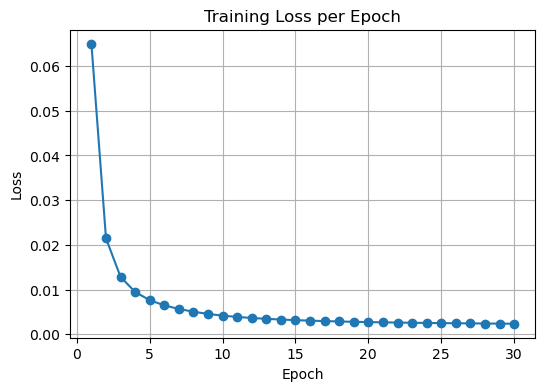

In [7]:


epoch_losses = []

for epoch in range(num_epochs):
    running_loss = 0.0
    n_batches = 0

    for imgs, _ in train_loader:
        imgs = imgs.to(device)

        optimizer.zero_grad(set_to_none=True)
        outputs = model(imgs)
        loss = criterion(outputs, imgs)    
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        n_batches += 1

    avg_loss = running_loss / n_batches
    epoch_losses.append(avg_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

# ---- Plot loss curve ----
plt.figure(figsize=(6,4))
plt.plot(range(1, num_epochs+1), epoch_losses, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss per Epoch")
plt.grid(True)
plt.show()

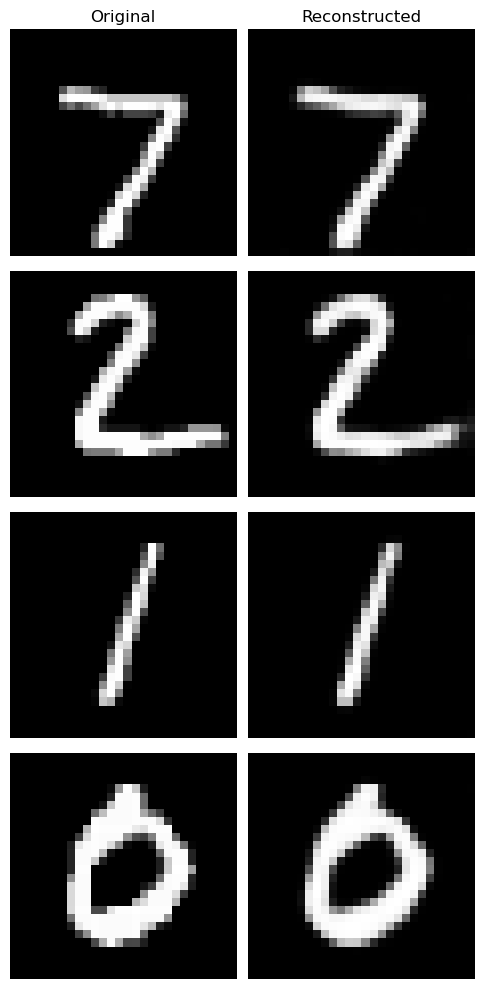

In [8]:
# put model in eval mode
model.eval()

# grab one batch
dataiter = iter(test_loader)
images, _ = next(dataiter)

# move to the same device & layout as training
imgs_dev = images.to(device, non_blocking=True, memory_format=torch.channels_last)

with torch.no_grad():  # no grads for inference
    outputs = model(imgs_dev)

# bring back to CPU for numpy/matplotlib
images_np = images.cpu().numpy()           # (N, 1, 28, 28)
outputs_np = outputs.detach().cpu().numpy()  # already (N, 1, 28, 28)

# number to display (don’t assume full batch)
num_images = min(4, images_np.shape[0])

fig, axes = plt.subplots(nrows=num_images, ncols=2, figsize=(5, 10))
for i in range(num_images):
    # original
    ax = axes[i, 0]
    ax.imshow(np.squeeze(images_np[i]), cmap="gray")
    ax.axis("off")
    if i == 0:
        ax.set_title("Original")

    # reconstructed
    ax = axes[i, 1]
    ax.imshow(np.squeeze(outputs_np[i]), cmap="gray")
    ax.axis("off")
    if i == 0:
        ax.set_title("Reconstructed")

plt.tight_layout()
plt.show()